# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import matplotlib.pyplot as plt
% matplotlib inline
import skimage.transform
import math

asset_folder = "./Project_data/"
number_classification = 5

In [2]:
# STEP 1 : Standardise and normalize image (Change Aspect ratio, Image Augmenting -> Random horizontal, Horizontal flip, Random cropping, Gausian noise adding, imageaug library, Embedding of image)
# STEP 2 : Generator
# STEP 3 : Architecture of Model (Dropupouts, Batch normalization, No large kernel, Increase channel gradually and Decrease image gradually simultaneously, Conv 1d -> to reduce number of parameters and depth)
# STEP 4 : Optimizer (Reduced NR Plateu, RNS Prop, SDC + Momentum, )
# STEP 5 : Epoch and Learning Rate (0.01, Cyclic Running rate)
# STEP 6 : RNN (GRU + TimeDistributed)

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

/Users/dev/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open(asset_folder + 'train.csv').readlines())
val_doc = np.random.permutation(open(asset_folder + 'val.csv').readlines())
batch_size = 2#experiment with the batch size

In [4]:
# Find all image sizes and then choose right min and max for it. Bound image and then add padding to it
t = np.random.permutation(train_doc)
source_path = asset_folder + 'train'
for image_index in range(0,5):
    folder = t[image_index].split(';')[0]
    imgs = os.listdir(source_path+'/'+ folder)
    image = imread(source_path+'/'+ folder+'/'+imgs[0])
    print(image.shape)


(120, 160, 3)
(120, 160, 3)
(120, 160, 3)
(120, 160, 3)
(120, 160, 3)


/Users/dev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


In [5]:
# Functions used in app

def resizeImageToSquare(image, size):
    dtype = image.dtype
    image = skimage.transform.resize(
            image, (size, size),
            order=1,
            mode='constant',
            preserve_range=True)
    return image.astype(dtype)

# Sizes found to be 120 * 160 and 360*360. 
# Experiment 1:
# If we resize 120 * 160 to 270 * 360 and add padding center padding to it
expected_size = 360
def standardiseImageToSquareByAddingPadding(image, ouput_size = expected_size):
    image = resizeImageToSquare(image, expected_size)
    return image

def normalizeImage(image):
    return image/255

/Users/dev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


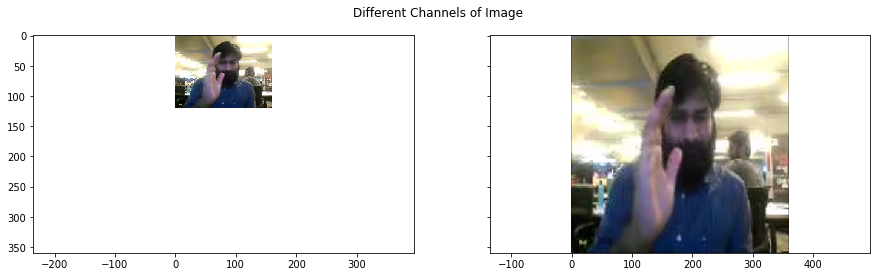

In [7]:
# Test : standardiseImageToSquareByAddingPadding and normalizeImage
# Find all image sizes and then choose right min and max for it. Bound image and then add padding to it
t = np.random.permutation(train_doc)
for image_index in range(0,1):
    folder = t[image_index].split(';')[0]
    imgs = os.listdir(source_path+'/'+ folder)
    image = imread(source_path+'/'+ folder+'/'+imgs[0])
    resize_image = resizeImageToSquare(image, 360)
    # plotting the original image and the RGB channels
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.set_figwidth(15)
    ax1.imshow(image)
    ax2.imshow(resize_image)
    f.suptitle('Different Channels of Image')

In [8]:
# Test : to check if we get batch size and index the way we want
# number_of_element_in_batch <= bs 
# index_batch from (0 to 100), unique
input_range = range(0,3)
folder_list = list(input_range)
bs = 34
for batch in range(0, len(folder_list), bs):
    if (batch + bs) >= len(folder_list):
        internal_batch_size = len(folder_list) - batch
    else:
        internal_batch_size = bs   
    assert 0 < internal_batch_size <= bs, "wrong calculation for internal_batch_size"
    for folder in range(internal_batch_size):
        index_batch = folder + batch
        print(index_batch)

0
1
2


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
img_idx = range(1, 30, 2) #create a list of image numbers you want to use for a particular video
x = len(img_idx) # Assumption is that we will get all image of index
y = z = expected_size
def generator(source_path, folder_list, batch_size):
    while True:
        t = np.random.permutation(folder_list)
        for batch in range(0, len(t), batch_size):
            if (batch + batch_size) >= len(t):
                internal_batch_size = len(t) - batch
            else:
                internal_batch_size = batch_size   
                
            batch_data = np.zeros((internal_batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((internal_batch_size, number_classification)) # batch_labels is the one hot representation of the output
            for folder in range(internal_batch_size): # iterate over the batch_size
                index_batch = folder + batch
                imgs = os.listdir(source_path+'/'+ t[index_batch].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[index_batch].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = standardiseImageToSquareByAddingPadding(image)
                    image = normalizeImage(image)
                    
                    batch_data[folder,idx,:,:,0] = image[:, : , 0]#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:, : , 1]#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:, : , 2]#normalise and feed in the image
                    
                batch_labels[folder, int(t[index_batch].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        # NOTE : taken care in above for loop

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = asset_folder + 'train'
val_path = asset_folder + 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 1# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 1


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

#write your model here

In [12]:
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
                 input_shape = (x,y,z,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(32, (3, 3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Dropout(0.25))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(64, (3, 3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dense(64, kernel_regularizer=l2(0.01)))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(number_classification))
model.add(Activation('softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [13]:
optimiser = 'sgd'#write your optimizer momentum
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 15, 360, 360, 32)  2624      
_________________________________________________________________
activation_7 (Activation)    (None, 15, 360, 360, 32)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 360, 360, 32)  128       
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 13, 358, 358, 32)  27680     
_________________________________________________________________
activation_8 (Activation)    (None, 13, 358, 358, 32)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 13, 358, 358, 32)  128       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 6, 179, 179, 32)   0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [14]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [16]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/1


/Users/dev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


  2/332 [..............................] - ETA: 24:13:03 - loss: 8.7484 - categorical_accuracy: 0.2500

In [175]:
# Test : 
po = next(train_generator)[0]
po.shape

/Users/dev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
